In [1]:
import pandas as pd
import random
import numpy as np
import leidenalg
import igraph as ig

from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA

from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import SpectralEmbedding

from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class exp_data():
    
    def __init__(self, name) -> None:
        """
        初始化函数
        """
        self.name = name
        self.data_mtx = None
        self.real_lables = None
        self.pc = None
        self.pca_method = None
        self.cluster_labels = None
        self.cluster_method = None
        self.silhouette_score = None
        self.ari_score = None
        self.nmi_score = None

    def load_data(self):

        name = self.name
        # 读取数据
        df = pd.read_csv(filepath_or_buffer= paths[name], index_col=0)
        # 读取标签
        color_labels_path = ans_paths[name]
        color_labels_df = pd.read_csv(color_labels_path, index_col=0, header=None)
        label_encoder = LabelEncoder()
        real_lable = label_encoder.fit_transform(color_labels_df.index)
        # 标准化数据
        # 认为是稀疏的，with_mean=False
        data_mtx_std = StandardScaler(with_mean = False).fit_transform(df.values.T)

        # 读取数据    
        self.data_mtx = data_mtx_std.T
        self.real_labels = real_lable

        print(f"已读取{name}数据集,样本数为:{df.values.shape[1]},特征数为:{df.values.shape[0]}")

    def pca(self,method_name = "pca", n_components=3, kernel='poly', degree=1, gamma=1, n_neighbors=10, init="random", perplexity=30, n_iter=800):
        """
        使用不同的降维方法对数据进行降维。
        参数：
        method_name (str): 降维方法的名称，可选值包括 'pca', 'kpca', 'isomap', 'lle', 'fica', 'fa', 'tsvd', 'se'，默认为 'pca'。
        kernel (str): 核函数类型，仅在使用 'kpca' 方法时有效，可选值为 'poly' 或 'rbf'，默认为 'poly'。
        degree (int): 多项式核函数的度数，仅在使用 'kpca' 方法时有效，默认为1。
        gamma (float): RBF核函数的参数，仅在使用 'kpca' 方法时有效，默认为1。
        n_neighbors (int): 每个点的邻居数，仅在使用 'isomap' 和 'lle' 方法时有效，默认为5。
        init (str): 初始化方法，仅在使用 'tsne' 方法时有效，默认为 'random'，可选值为 'pca'。
        perplexity (float): 有效邻居点数量，仅在使用 'tsne' 方法时有效，默认为30。
        n_iter (int): 迭代次数，仅在使用 'tsne' 方法时有效，默认为800。
        
        该函数会更新对象的属性 self.pc 和 self.pca_method，分别保存降维后的数据和使用的降维方法。
        """
        data_mtx = self.data_mtx
        real_lable = self.real_labels
        kernel = kernel
        deg = degree
        gam = gamma
        n_neighbors = n_neighbors
        init = init
        perplexity = perplexity
        n_iter = n_iter

        # 子函数参数通过父函数参数传入

        def fa():
            """
            使用因子分析（Factor Analysis）进行降维。
            参数:
            n_components (int): 降维后的目标维数，默认为3。
            返回:
            tuple: 包含降维后的数据和PCA类型的元组。
            """
            pca_type = 'Factor Analysis'
            fa = FactorAnalysis(n_components=n_components, random_state=0)
            data_fa = fa.fit_transform(data_mtx.T)
            print("principal_components Shape:",data_fa.shape)
            return data_fa, pca_type

        def fica():
            """
            使用独立成分分析（FastICA）进行降维。
            参数:
            n_components (int): 降维后的目标维数，默认为3。
            返回:
            tuple: 包含以下两个元素的元组：
                - data_fica (ndarray): 降维后的数据矩阵。
                - pca_type (str): 降维方法的类型，固定为'Fast Independent Component Analysis'。
            """
            pca_type = 'Fast Independent Component Analysis'
            fica = FastICA(n_components=n_components, random_state=42,whiten='unit-variance')
            data_fica = fica.fit_transform(data_mtx.T)
            print("principal_components Shape:",data_fica.shape)
            return data_fica, pca_type

        def lpca():
            """
            执行主成分分析（PCA）并返回降维后的数据和PCA类型。
            参数:
            n_components (int): 要保留的主成分数量，默认为3。
            返回:
            tuple: 包含降维后的数据和PCA类型的元组。
            """    
            pca_type = 'Linear'
            pca = PCA(n_components=n_components)
            data_linear_pca = pca.fit_transform(data_mtx.T)
            print("principal_components Shape:",data_linear_pca.shape)
            return data_linear_pca,pca_type

        def kpca():
            """
            使用核主成分分析（Kernel PCA）进行降维。
            参数:
            n_components (int): 选择的主成分数量，默认值为3。
            kernel (str): 核函数类型，可以是 'rbf' 或 'poly'，默认值为 'poly'。
            degree (int): 多项式核函数的度数，默认值为1。
            gamma (float): RBF核函数的参数，默认值为1。
            返回:
            tuple: 包含降维后的数据和PCA类型的元组。
            """
            pca_type = 'Kernel'
            degree = deg 
            gamma = gam 
            print(f"Computing polomial kernel matrix with degree = {degree} and RBF kernel of gamma = {gamma}...")
            K_poly = polynomial_kernel(data_mtx.T, degree=degree)
            K_rbf = rbf_kernel(data_mtx.T, gamma=gamma)
            print("RBF and polynomial kernel matrix computed.")

            # 对应核函数的核矩阵
            if kernel == 'poly':
                K = K_poly
            elif kernel == 'rbf':
                K = K_rbf

            # Center the kernel matrix
            ones = np.ones(K.shape) / K.shape[0]
            K_centered= K - ones @ K - K @ ones + ones @ K @ ones
            print("Kernel matrix centered.")

            # Compute largest k eigenvalues of kernel matrix
            k = n_components
            print(f"Computing the first {k} largest eigenvalues and eigenvectors...")
            # eigh returns eigenvalues in ascending order, so we need to get the last k
            eigenvalues, eigenvectors = eigh(K_centered, eigvals=(K_centered.shape[0]-k, K_centered.shape[0]-1))
            print("Eigenvalue decomposition completed.")
            print(f"First {k} eigenvalues represent {sum(eigenvalues)/K_centered.trace()} of all features")

            data_k_pca = eigenvectors

            return data_k_pca, pca_type

        def isomap():
            """
            使用等距特征映射（Isomap）进行降维。
            参数:
            n_components (int): 降维后的目标维数，默认值为3。
            n_neighbors (int): 每个点的邻居数，默认值为200。
            返回:
            tuple: 包含以下两个元素的元组：
                - data_isomap (ndarray): 降维后的数据矩阵。
                - pca_type (str): 降维方法的类型，固定为'Isomap'。
            """
            pca_type = 'Isomap'
            # Perform Isometric Feature Mapping (Isomap)
            isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
            data_isomap = isomap.fit_transform(data_mtx.T)

            # print("Isomap completed.")
            print("principal_components Shape:", data_isomap.shape)
            return data_isomap, pca_type

        def lle():
            """
            局部线性嵌入 (Locally Linear Embedding)，该非线性降维方法结果具有随机性。
            参数:
            n_components (int): 嵌入空间的维数，默认为3。
            n_neighbors (int): 每个点的邻居数量，默认为5。
            返回:
            tuple: 包含以下两个元素的元组
                - data_lle (ndarray): 经过局部线性嵌入后的数据矩阵。
                - pca_type (str): 表示PCA类型的字符串，值为 'Locally Linear Embedding'。
            """

            """Locally Linear Embedding"""
            pca_type = 'Locally Linear Embedding'
            lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, random_state=40)
            data_lle = lle.fit_transform(data_mtx.T)
            print("primcipal_components Shape:", data_lle.shape)
            return data_lle, pca_type

    
        def se():
            """
            使用谱嵌入（Spectral Embedding）进行降维。
            参数:
            n_components (int): 降维后的目标维数，默认为3。
            返回:
            tuple: 包含降维后的数据和PCA类型的元组。
            """
            pca_type = 'Spectral Embedding'
            se = SpectralEmbedding(n_components=n_components, random_state=40)
            data_se = se.fit_transform(data_mtx.T)
            print("principal_components Shape:",data_se.shape)
            return data_se, pca_type

        pca_functions = {"pca":lpca, "kpca":kpca, "isomap":isomap, "lle":lle, "fica":fica, "fa":fa, "se":se}
        # 保存主成分
        pca_func = pca_functions[method_name]
        self.pc, remark = pca_func()
        self.pca_method = pca_func.__name__
        
        print(f"使用{pca_func.__name__}方法,注：{remark}")
        
    
    def compute_silhouette_score(self,clustered=False):
        """
        计算轮廓系数。
        参数:
        
        """
        data = self.pc
        # real为默认为真，计算真实标签下的轮廓系数，否则计算聚类标签下的轮廓系数
        if clustered:
            label = self.cluster_labels
        else:
            label = self.real_labels
        score = silhouette_score(data, label)
        self.silhouette_score = score

        return score

    def plot(self,clustered=False):
        """
        绘制降维后的数据散点图,细胞依据给定的类别用不同颜色表示，呈现分散效果。
        参数:
        pca_func (tuple): 包含降维后的数据和PCA类型的元组。
        clustered (bool): 是否使用聚类标签，默认为False。
        """
        # 创建图形和3D坐标轴
        fig = plt.figure(figsize=(8, 6))

        ax = fig.add_subplot(111, projection='3d')

        data = self.pc
        
        if clustered:
            color_label = self.cluster_labels
        else:
            color_label = self.real_labels

        # 绘制散点图
        scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color_label, cmap='viridis', s=4)

        # 完全隐藏坐标
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        plt.show()

    def kmeans_clustering(self, n_clusters=None):
        """
        使用K均值算法对数据进行聚类。
        参数:
        n_clusters (int): 聚类数，默认为None。
        返回:
        无返回值。该方法会更新以下实例属性：
        - self.cluster_labels: 聚类标签。
        - self.cluster_method: 聚类方法名称，固定为 'kmeans'。
        - self.ari_score: 调整兰德指数（ARI）得分。
        - self.nmi_score: 归一化互信息（NMI）得分。
        """
        real_lable = self.real_labels
        # 真实标签细胞种类数作为聚类数
        n_clusters = real_lable.max() + 1
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(self.pc)
        labels = kmeans.labels_

        # 计算（ARI）得分
        ari_score = adjusted_rand_score(real_lable, labels)
        # print(f"ARI 分数为: {ari_score}")

        # 计算（NMI）得分
        nmi_score = normalized_mutual_info_score(real_lable, labels)
        # print(f"NMI 分数为: {nmi_score}")
        
        self.cluster_labels = labels
        self.cluster_method = 'kmeans'
        self.ari_score = ari_score
        self.nmi_score = nmi_score


    def leiden_clustering(self, n_neighbors=5):
        """
            使用Leiden算法对数据进行聚类。
            参数:
            n_neighbors (int): 每个点的邻居数，默认为5。
            返回:
            无返回值。该方法会更新以下实例属性：
            - self.cluster_labels: 聚类标签。
            - self.cluster_method: 聚类方法名称，固定为 'leiden'。
            - self.ari_score: 调整兰德指数（ARI）得分。
            - self.nmi_score: 归一化互信息（NMI）得分。
            """
        real_lable = self.real_labels

        knn_graph = kneighbors_graph(self.pc, n_neighbors=n_neighbors, include_self=False)
        sources, targets = knn_graph.nonzero()
        edges = list(zip(sources, targets))
        G = ig.Graph(edges=edges, directed=False)

        partition = leidenalg.find_partition(G, partition_type=leidenalg.RBConfigurationVertexPartition, seed=42)

        labels = np.array(partition.membership)
        
        # 计算（ARI）得分
        ari_score = adjusted_rand_score(real_lable, labels)
        # print(f"ARI 分数为: {ari_score}")

        # 计算（NMI）得分
        nmi_score = normalized_mutual_info_score(real_lable, labels)
        # print(f"NMI 分数为: {nmi_score}")
        
        self.cluster_labels = labels
        self.cluster_method = 'leiden'
        self.ari_score = ari_score
        self.nmi_score = nmi_score



    def mclustering(self, model_name = "gmm"):
        """
        使用高斯混合模型（GMM）或贝叶斯高斯混合模型（BGMM）对数据进行聚类。
        参数:
        model_name (str): 指定使用的模型名称，可以是 "gmm" 或 "bgmm"。默认为 "gmm"。
        返回:
        无返回值。该方法会更新以下实例属性：
        - self.cluster_labels: 聚类标签。
        - self.cluster_method: 聚类方法名称，固定为 'mclust'。
        - self.ari_score: 调整兰德指数（ARI）得分。
        - self.nmi_score: 归一化互信息（NMI）得分。
        """
        real_lable = self.real_labels

        X = self.pc

        gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
        bgmm = BayesianGaussianMixture(n_components=3, covariance_type='full', random_state=0)

        models = {"gmm":gmm, "bgmm":bgmm}
        model = models[model_name] 
        model.fit(X)

        labels = model.predict(X)

        centroids = model.means_
         

        # 计算 (ARI) 得分 
        ari_score = adjusted_rand_score(real_lable, labels)
        # print(f"ARI 分数为： {ari_score}")

        # 计算 (NMI) 得分
        nmi_score = normalized_mutual_info_score(real_lable, labels)
        # print(f"NMI 分数为： {nmi_score}")

        self.cluster_labels = labels
        self.cluster_method = 'mclust'
        self.ari_score = ari_score
        self.nmi_score = nmi_score

In [3]:
paths = {'deng':'./set2/deng.logcounts.csv','seger':'./set3/seger.logcounts.csv','zeisel':'./set4/zeisel.logcounts.csv'}
ans_paths = {'deng':'./set2/set2.ans.csv','seger':'./set3/set3.ans.csv','zeisel':'./set4/set4.ans.csv'}

## 实验最佳结果

In [4]:
exp_0 = exp_data('deng')
exp_0.load_data()
exp_0.pca(method_name='pca')

exp_1 = exp_data('seger')
exp_1.load_data()
exp_1.pca(method_name='pca')

exp_2 = exp_data('zeisel')
exp_2.load_data()
exp_2.pca(method_name='pca')


已读取deng数据集,样本数为:268,特征数为:22431
principal_components Shape: (268, 3)
使用lpca方法,注：Linear
已读取seger数据集,样本数为:1099,特征数为:25525
principal_components Shape: (1099, 3)
使用lpca方法,注：Linear
已读取zeisel数据集,样本数为:3005,特征数为:19972
principal_components Shape: (3005, 3)
使用lpca方法,注：Linear


In [5]:
exp_3 = exp_data('deng')
exp_3.load_data()
exp_3.pca(method_name='lle',n_neighbors=79)

exp_4 = exp_data('seger')
exp_4.load_data()
exp_4.pca(method_name='lle',n_neighbors=216)

exp_5 = exp_data('zeisel')
exp_5.load_data()
exp_5.pca(method_name='lle',n_neighbors=166)


已读取deng数据集,样本数为:268,特征数为:22431
primcipal_components Shape: (268, 3)
使用lle方法,注：Locally Linear Embedding
已读取seger数据集,样本数为:1099,特征数为:25525
primcipal_components Shape: (1099, 3)
使用lle方法,注：Locally Linear Embedding
已读取zeisel数据集,样本数为:3005,特征数为:19972
primcipal_components Shape: (3005, 3)
使用lle方法,注：Locally Linear Embedding


### 降维后散点图

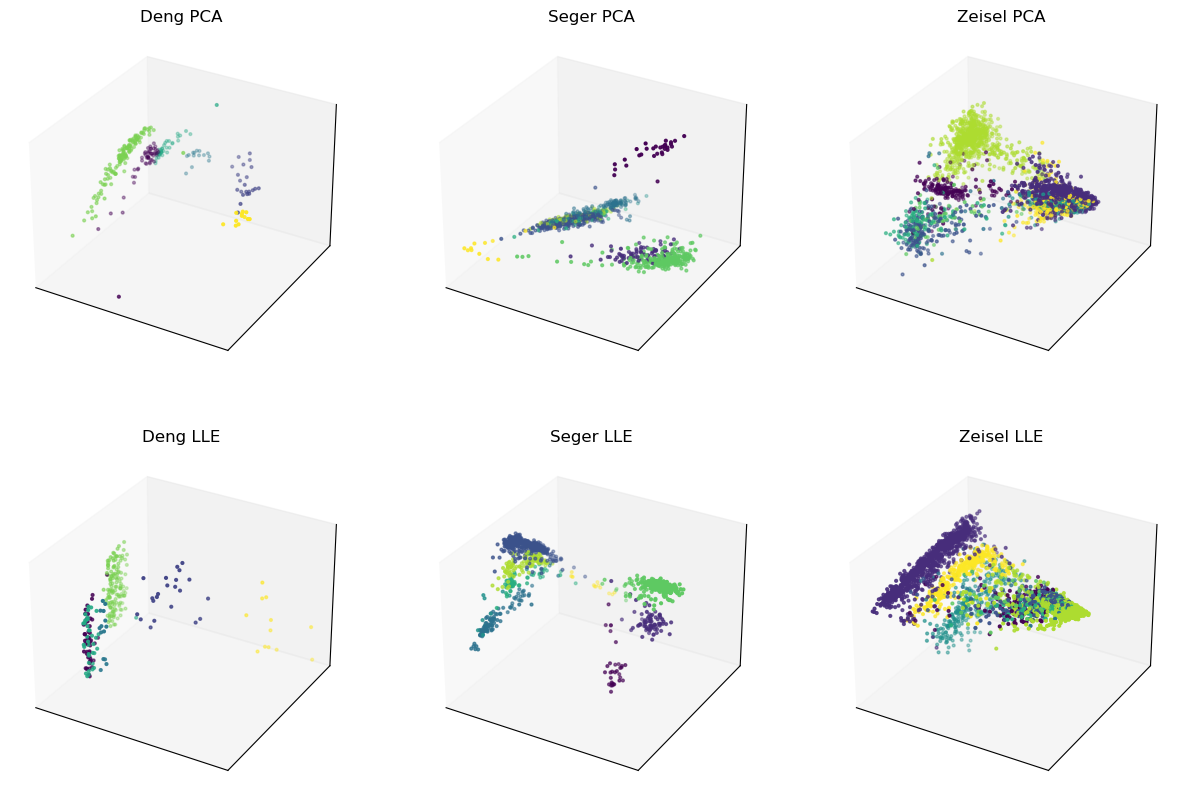

In [7]:
# 绘制2行3列一共6个散点图
fig = plt.figure(figsize=(15, 10))

# 绘制第一行    
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax3 = fig.add_subplot(2, 3, 3, projection='3d')

# 绘制第二行
ax4 = fig.add_subplot(2, 3, 4, projection='3d')
ax5 = fig.add_subplot(2, 3, 5, projection='3d')
ax6 = fig.add_subplot(2, 3, 6, projection='3d')

# 绘制第一行
scatter = ax1.scatter(exp_0.pc[:, 0], exp_0.pc[:, 1], exp_0.pc[:, 2], c=exp_0.real_labels, cmap='viridis', s=4)
ax1.set_title('Deng PCA')
ax1.grid(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

scatter = ax2.scatter(exp_1.pc[:, 0], exp_1.pc[:, 1], exp_1.pc[:, 2], c=exp_1.real_labels, cmap='viridis', s=4)
ax2.set_title('Seger PCA')
ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

scatter = ax3.scatter(exp_2.pc[:, 0], exp_2.pc[:, 1], exp_2.pc[:, 2], c=exp_2.real_labels, cmap='viridis', s=4)
ax3.set_title('Zeisel PCA')
ax3.grid(False)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_zticks([])

# 绘制第二行
scatter = ax4.scatter(exp_3.pc[:, 0], exp_3.pc[:, 1], exp_3.pc[:, 2], c=exp_3.real_labels, cmap='viridis', s=4)
ax4.set_title('Deng LLE')
ax4.grid(False)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_zticks([])
scatter = ax5.scatter(exp_4.pc[:, 0], exp_4.pc[:, 1], exp_4.pc[:, 2], c=exp_4.real_labels, cmap='viridis', s=4)

ax5.set_title('Seger LLE')
ax5.grid(False)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_zticks([])

scatter = ax6.scatter(exp_5.pc[:, 0], exp_5.pc[:, 1], exp_5.pc[:, 2], c=exp_5.real_labels, cmap='viridis', s=4)
ax6.set_title('Zeisel LLE')
ax6.grid(False)
ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_zticks([])

plt.show()



In [6]:
exp_3.mclustering()
exp_4.mclustering(model_name='bgmm')
exp_5.mclustering(model_name='bgmm')


# 计算ARI和NMI分数

print(f"Deng数据集的ARI分数为: {exp_3.ari_score}")
print(f"Deng数据集的NMI分数为: {exp_3.nmi_score}")

print(f"Seger数据集的ARI分数为: {exp_4.ari_score}")
print(f"Seger数据集的NMI分数为: {exp_4.nmi_score}")

print(f"Zeisel数据集的ARI分数为: {exp_5.ari_score}")
print(f"Zeisel数据集的NMI分数为: {exp_5.nmi_score}")

c:\Users\30983\miniconda3\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\30983\miniconda3\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Deng数据集的ARI分数为: 0.8320734723226868
Deng数据集的NMI分数为: 0.8164637044183171
Seger数据集的ARI分数为: 0.6336346773171116
Seger数据集的NMI分数为: 0.633877172797456
Zeisel数据集的ARI分数为: 0.5139040043285228
Zeisel数据集的NMI分数为: 0.5350547949525852


### 真实分类与聚类分类下轮廓系数

In [8]:
print("deng数据集真实分类下轮廓系数为：",exp_3.compute_silhouette_score())
print("seger数据集真实分类下轮廓系数为：",exp_4.compute_silhouette_score())
print("zeisel数据集真实分类下轮廓系数为：",exp_5.compute_silhouette_score())
print("---")
print("deng数据集Mclust分类下轮廓系数为：",exp_3.compute_silhouette_score(clustered=True))
print("seger数据集Mclust分类下轮廓系数为：",exp_4.compute_silhouette_score(clustered=True))
print("zeisel数据集Mclust分类下轮廓系数为：",exp_5.compute_silhouette_score(clustered=True))

deng数据集真实分类下轮廓系数为： 0.30441404926238896
seger数据集真实分类下轮廓系数为： 0.2793780841879841
zeisel数据集真实分类下轮廓系数为： 0.14939166489156247
---
deng数据集Mclust分类下轮廓系数为： 0.4320047933431634
seger数据集Mclust分类下轮廓系数为： 0.47094839366237495
zeisel数据集Mclust分类下轮廓系数为： 0.4335021655302733


## Deng数据集上分析降维方法


In [ ]:
exp_0 = exp_data('deng')
exp_0.load_data()
exp_0.pca(method_name='pca')
exp_1 = exp_data('deng')
exp_1.load_data()
exp_1.pca(method_name='kpca',kernel='poly',degree=2)
exp_2 = exp_data('deng')
exp_2.load_data()
exp_2.pca(method_name='fa',kernel='rbf',gamma=0.1)
exp_3 = exp_data('deng')
exp_3.load_data()
exp_3.pca(method_name='fica',n_neighbors=5)
exp_4 = exp_data('deng')
exp_4.load_data()
exp_4.pca(method_name='isomap',n_neighbors=5)
exp_5 = exp_data('deng')
exp_5.load_data()
exp_5.pca(method_name='lle',n_neighbors=5)
exp_6 = exp_data('deng')
exp_6.load_data()
exp_6.pca(method_name='se',n_neighbors=5)

### 不同降维散点图

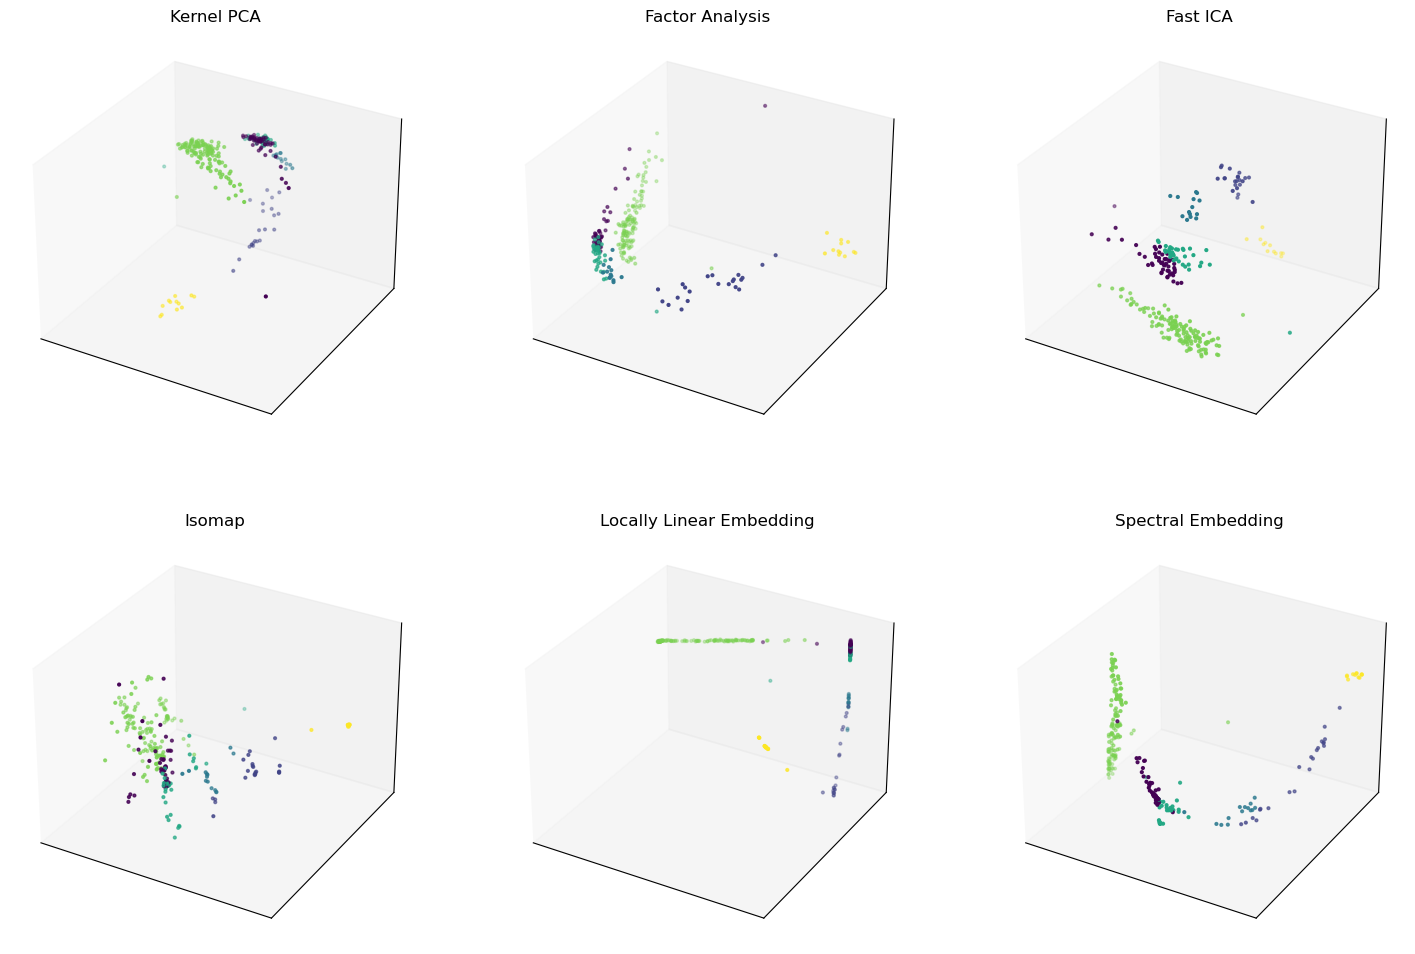

In [35]:
fig = plt.figure(figsize=(18, 12))

# 绘制6个三维散点图
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1 , projection='3d')
    data = [exp_1.pc, exp_2.pc, exp_3.pc, exp_4.pc, exp_5.pc, exp_6.pc]
    labels = [exp_1.real_labels, exp_2.real_labels, exp_3.real_labels, exp_4.real_labels, exp_5.real_labels, exp_6.real_labels]
    remarks = ['Kernel PCA', 'Factor Analysis', 'Fast ICA', 'Isomap', 'Locally Linear Embedding', 'Spectral Embedding']
    ax.scatter(data[i][:, 0], data[i][:, 1], data[i][:, 2], c=labels[i], cmap='viridis', s=4)
    ax.set_title(f'{remarks[i]}')
    # 完全隐藏坐标
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.show()

# 第一行

### 在真实分类下轮廓系数

In [36]:
print(exp_0.pca_method, exp_0.compute_silhouette_score())
print(exp_1.pca_method, exp_1.compute_silhouette_score())
print(exp_2.pca_method, exp_2.compute_silhouette_score())
print(exp_3.pca_method, exp_3.compute_silhouette_score())
print(exp_4.pca_method, exp_4.compute_silhouette_score())
print(exp_5.pca_method, exp_5.compute_silhouette_score())
print(exp_6.pca_method, exp_6.compute_silhouette_score())

lpca 0.3642695263192491
kpca 0.3337349554974357
fa 0.3291882588398935
fica 0.33373495549743554
isomap 0.33584867100874716
lle 0.5119352646804121
se 0.32191514768061513
